<a href="https://colab.research.google.com/github/liviaceciliags/GoldFever/blob/main/train_rt_detr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train RT-DETR on Custom Dataset

---

[![arXiv](https://img.shields.io/badge/arXiv-2304.08069-b31b1b.svg)](https://arxiv.org/pdf/2304.08069.pdf)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/lyuwenyu/RT-DETR)

RT-DETR, short for "Real-Time DEtection TRansformer", is a computer vision model developed by Peking University and Baidu. In their paper, "DETRs Beat YOLOs on Real-time Object Detection" the authors claim that RT-DETR can outperform YOLO models in object detection, both in terms of speed and accuracy. The model has been released under the Apache 2.0 license, making it a great option, especially for enterprise projects.

![RT-DETR Figure.1](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/rt-detr-figure-1.png)

Recently, RT-DETR was added to the `transformers` library, significantly simplifying its fine-tuning process. In this tutorial, we will show you how to train RT-DETR on a custom dataset.

## Setup

### Configure your API keys

To fine-tune RT-DETR, you need to provide your HuggingFace Token and Roboflow API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `L4 GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Mon Jun 30 08:58:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
%cd /content/drive/MyDrive/LiviaCecilia/RT_DETR
HOME = os.getcwd()
print(HOME)

/content/drive/MyDrive/LiviaCecilia/RT_DETR
/content/drive/MyDrive/LiviaCecilia/RT_DETR


### Install dependencies

In [4]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q git+https://github.com/roboflow/supervision.git
!pip install -q accelerate
!pip install -q roboflow
!pip install -q torchmetrics
!pip install -q "albumentations>=1.4.5"
!pip install pillow-heif==0.12.0
!pip install --upgrade supervision


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Imports

In [5]:
import torch
import requests

import numpy as np
import supervision as sv
import albumentations as A

from PIL import Image
from pprint import pprint
from roboflow import Roboflow
from dataclasses import dataclass, replace
from google.colab import userdata
from torch.utils.data import Dataset
from transformers import (
    AutoImageProcessor,
    AutoModelForObjectDetection,
    TrainingArguments,
    Trainer
)
from torchmetrics.detection.mean_ap import MeanAveragePrecision


## Inference with pre-trained RT-DETR model

In [6]:
# @title Load model

CHECKPOINT = "PekingU/rtdetr_r50vd_coco_o365"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForObjectDetection.from_pretrained(CHECKPOINT).to(DEVICE)
processor = AutoImageProcessor.from_pretrained(CHECKPOINT)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
# @title Run inference

URL = "https://media.roboflow.com/notebooks/examples/dog.jpeg"

image = Image.open(requests.get(URL, stream=True).raw)
inputs = processor(image, return_tensors="pt").to(DEVICE)

with torch.no_grad():
    outputs = model(**inputs)

w, h = image.size
results = processor.post_process_object_detection(
    outputs, target_sizes=[(h, w)], threshold=0.5)

In [ ]:
# @title Display result with NMS

detections = sv.Detections.from_transformers(results[0]).with_nms(threshold=0.3)
labels = [
    model.config.id2label[class_id]
    for class_id
    in detections.class_id
]

annotated_image = image.copy()
annotated_image = sv.BoxAnnotator().annotate(annotated_image, detections)
annotated_image = sv.LabelAnnotator().annotate(annotated_image, detections, labels=labels)
annotated_image.thumbnail((600, 600))
annotated_image

NameError: name 'results' is not defined

## Fine-tune RT-DETR on custom dataset

In [7]:
# @title Download dataset from Roboflow Universe
# Configurar as chaves de API
from roboflow import Roboflow
ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
HF_TOKEN = userdata.get('HF_TOKEN')

rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("ic-fgbe1").project("ic-xgmobile")
version = project.version(16)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...


In [8]:
ds_train = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/train",
    annotations_path=f"{dataset.location}/train/_annotations.coco.json",
)
ds_valid = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/valid",
    annotations_path=f"{dataset.location}/valid/_annotations.coco.json",
)
ds_test = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

print(f"Number of training images: {len(ds_train)}")
print(f"Number of validation images: {len(ds_valid)}")
print(f"Number of test images: {len(ds_test)}")

Number of training images: 2703
Number of validation images: 551
Number of test images: 550


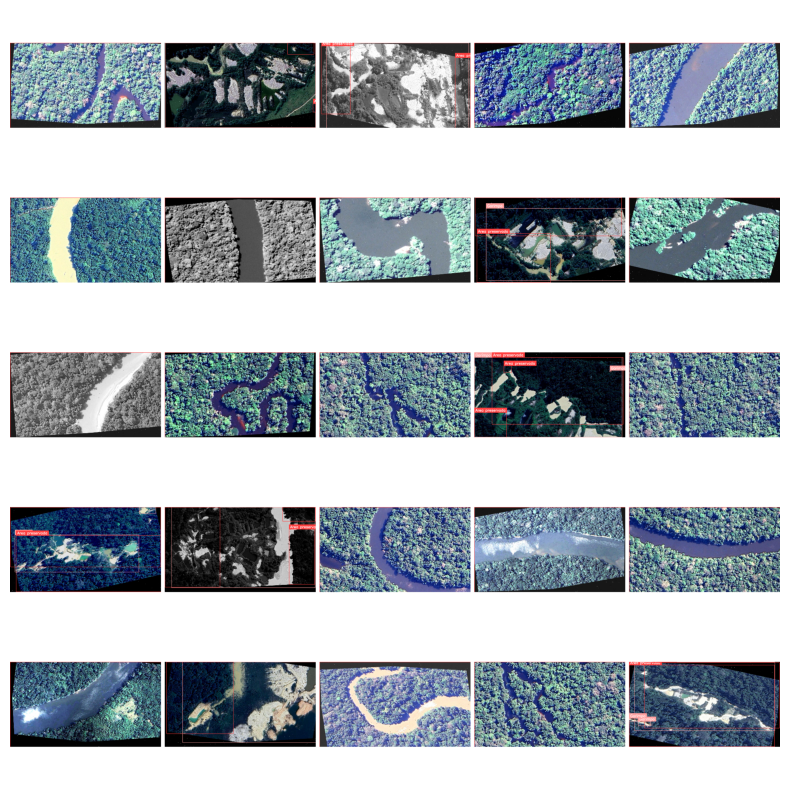

In [9]:
# @title Display dataset sample

GRID_SIZE = 5

def annotate(image, annotations, classes):
    labels = [
        classes[class_id]
        for class_id
        in annotations.class_id
    ]

    # Change this line:
    bounding_box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator(text_scale=1, text_thickness=2)

    annotated_image = image.copy()
    annotated_image = bounding_box_annotator.annotate(annotated_image, annotations)
    annotated_image = label_annotator.annotate(annotated_image, annotations, labels=labels)
    return annotated_image

annotated_images = []
for i in range(GRID_SIZE * GRID_SIZE):
    _, image, annotations = ds_train[i]
    annotated_image = annotate(image, annotations, ds_train.classes)
    annotated_images.append(annotated_image)

grid = sv.create_tiles(
    annotated_images,
    grid_size=(GRID_SIZE, GRID_SIZE),
    single_tile_size=(400, 400),
    tile_padding_color=sv.Color.WHITE,
    tile_margin_color=sv.Color.WHITE
)
sv.plot_image(grid, size=(10, 10))

### Preprocess the data

To finetune a model, you must preprocess the data you plan to use to match precisely the approach used for the pre-trained model. [AutoImageProcessor](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoImageProcessor) takes care of processing image data to create `pixel_values`, `pixel_mask`, and `labels` that a DETR model can train with. The image processor has some attributes that you won't have to worry about:

- `image_mean = [0.485, 0.456, 0.406 ]`
- `image_std = [0.229, 0.224, 0.225]`

These are the mean and standard deviation used to normalize images during the model pre-training. These values are crucial to replicate when doing inference or finetuning a pre-trained image model.

Instantiate the image processor from the same checkpoint as the model you want to finetune.

In [10]:
IMAGE_SIZE = 480

processor = AutoImageProcessor.from_pretrained(
    CHECKPOINT,
    do_resize=True,
    size={"width": IMAGE_SIZE, "height": IMAGE_SIZE},
)

Before passing the images to the `processor`, apply two preprocessing transformations to the dataset:

- Augmenting images
- Reformatting annotations to meet RT-DETR expectations

First, to make sure the model does not overfit on the training data, you can apply image augmentation with any data augmentation library. Here we use [Albumentations](https://albumentations.ai/docs/). This library ensures that transformations affect the image and update the bounding boxes accordingly.

In [11]:
train_augmentation_and_transform = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=25
    ),
)

valid_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=1
    ),
)

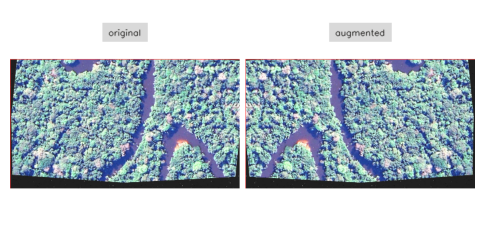

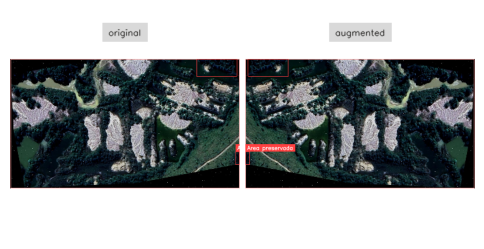

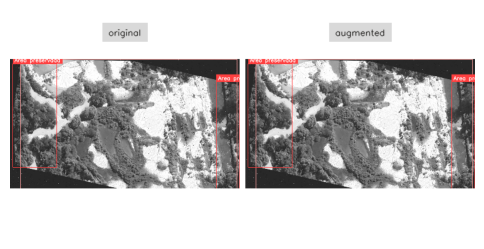

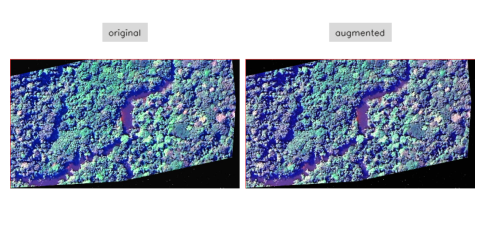

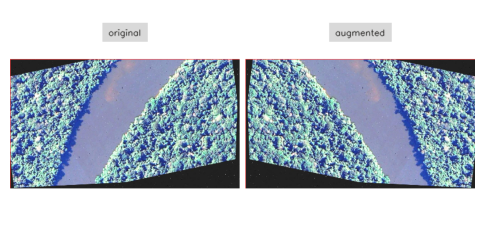

In [12]:
# @title Visualize some augmented images

IMAGE_COUNT = 5

for i in range(IMAGE_COUNT):
    _, image, annotations = ds_train[i]

    output = train_augmentation_and_transform(
        image=image,
        bboxes=annotations.xyxy,
        category=annotations.class_id
    )

    augmented_image = output["image"]
    augmented_annotations = replace(
        annotations,
        xyxy=np.array(output["bboxes"]),
        class_id=np.array(output["category"])
    )

    annotated_images = [
        annotate(image, annotations, ds_train.classes),
        annotate(augmented_image, augmented_annotations, ds_train.classes)
    ]
    grid = sv.create_tiles(
        annotated_images,
        titles=['original', 'augmented'],
        titles_scale=0.5,
        single_tile_size=(400, 400),
        tile_padding_color=sv.Color.WHITE,
        tile_margin_color=sv.Color.WHITE
    )
    sv.plot_image(grid, size=(6, 6))

The `processor` expects the annotations to be in the following format: `{'image_id': int, 'annotations': List[Dict]}`, where each dictionary is a COCO object annotation. Let's add a function to reformat annotations for a single example:

In [13]:
class PyTorchDetectionDataset(Dataset):
    def __init__(self, dataset: sv.DetectionDataset, processor, transform: A.Compose = None):
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    @staticmethod
    def annotations_as_coco(image_id, categories, boxes):
        annotations = []
        for category, bbox in zip(categories, boxes):
            x1, y1, x2, y2 = bbox
            formatted_annotation = {
                "image_id": image_id,
                "category_id": category,
                "bbox": [x1, y1, x2 - x1, y2 - y1],
                "iscrowd": 0,
                "area": (x2 - x1) * (y2 - y1),
            }
            annotations.append(formatted_annotation)

        return {
            "image_id": image_id,
            "annotations": annotations,
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        _, image, annotations = self.dataset[idx]

        # Convert image to RGB numpy array
        image = image[:, :, ::-1]
        boxes = annotations.xyxy
        categories = annotations.class_id

        if self.transform:
            transformed = self.transform(
                image=image,
                bboxes=boxes,
                category=categories
            )
            image = transformed["image"]
            boxes = transformed["bboxes"]
            categories = transformed["category"]


        formatted_annotations = self.annotations_as_coco(
            image_id=idx, categories=categories, boxes=boxes)
        result = self.processor(
            images=image, annotations=formatted_annotations, return_tensors="pt")

        # Image processor expands batch dimension, lets squeeze it
        result = {k: v[0] for k, v in result.items()}

        return result

Now you can combine the image and annotation transformations to use on a batch of examples:

In [14]:
pytorch_dataset_train = PyTorchDetectionDataset(
    ds_train, processor, transform=train_augmentation_and_transform)
pytorch_dataset_valid = PyTorchDetectionDataset(
    ds_valid, processor, transform=valid_transform)
pytorch_dataset_test = PyTorchDetectionDataset(
    ds_test, processor, transform=valid_transform)

pytorch_dataset_train[15]

{'pixel_values': tensor([[[0.1647, 0.1647, 0.1647,  ..., 0.1647, 0.1647, 0.1647],
          [0.1647, 0.1647, 0.1647,  ..., 0.1647, 0.1647, 0.1647],
          [0.1647, 0.1647, 0.1647,  ..., 0.1647, 0.1647, 0.1647],
          ...,
          [0.1647, 0.1647, 0.1647,  ..., 0.1647, 0.1647, 0.1647],
          [0.1647, 0.1647, 0.1647,  ..., 0.1647, 0.1647, 0.1647],
          [0.1647, 0.1647, 0.1647,  ..., 0.1647, 0.1647, 0.1647]],
 
         [[0.1647, 0.1647, 0.1647,  ..., 0.1647, 0.1647, 0.1647],
          [0.1647, 0.1647, 0.1647,  ..., 0.1647, 0.1647, 0.1647],
          [0.1647, 0.1647, 0.1647,  ..., 0.1647, 0.1647, 0.1647],
          ...,
          [0.1647, 0.1647, 0.1647,  ..., 0.1647, 0.1647, 0.1647],
          [0.1647, 0.1647, 0.1647,  ..., 0.1647, 0.1647, 0.1647],
          [0.1647, 0.1647, 0.1647,  ..., 0.1647, 0.1647, 0.1647]],
 
         [[0.1647, 0.1647, 0.1647,  ..., 0.1647, 0.1647, 0.1647],
          [0.1647, 0.1647, 0.1647,  ..., 0.1647, 0.1647, 0.1647],
          [0.1647, 0.164

You have successfully augmented the images and prepared their annotations. In the final step, create a custom collate_fn to batch images together.

In [15]:
def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    return data

## Preparing function to compute mAP

In [16]:
id2label = {id: label for id, label in enumerate(ds_train.classes)}
label2id = {label: id for id, label in enumerate(ds_train.classes)}


@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


class MAPEvaluator:

    def __init__(self, image_processor, threshold=0.3, id2label=None):
        self.image_processor = image_processor
        self.threshold = threshold
        self.id2label = id2label

    def collect_image_sizes(self, targets):
        """Collect image sizes across the dataset as list of tensors with shape [batch_size, 2]."""
        image_sizes = []
        for batch in targets:
            batch_image_sizes = torch.tensor(np.array([x["size"] for x in batch]))
            image_sizes.append(batch_image_sizes)
        return image_sizes

    def collect_targets(self, targets, image_sizes):
        post_processed_targets = []
        for target_batch, image_size_batch in zip(targets, image_sizes):
            for target, (height, width) in zip(target_batch, image_size_batch):
                boxes = target["boxes"]
                boxes = sv.xcycwh_to_xyxy(boxes)
                boxes = boxes * np.array([width, height, width, height])
                boxes = torch.tensor(boxes)
                labels = torch.tensor(target["class_labels"])
                post_processed_targets.append({"boxes": boxes, "labels": labels})
        return post_processed_targets

    def collect_predictions(self, predictions, image_sizes):
        post_processed_predictions = []
        for batch, target_sizes in zip(predictions, image_sizes):
            batch_logits, batch_boxes = batch[1], batch[2]
            output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
            post_processed_output = self.image_processor.post_process_object_detection(
                output, threshold=self.threshold, target_sizes=target_sizes
            )
            post_processed_predictions.extend(post_processed_output)
        return post_processed_predictions

    @torch.no_grad()
    def __call__(self, evaluation_results):

        predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

        image_sizes = self.collect_image_sizes(targets)
        post_processed_targets = self.collect_targets(targets, image_sizes)
        post_processed_predictions = self.collect_predictions(predictions, image_sizes)

        evaluator = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
        evaluator.warn_on_many_detections = False
        evaluator.update(post_processed_predictions, post_processed_targets)

        metrics = evaluator.compute()

        # Replace list of per class metrics with separate metric for each class
        classes = metrics.pop("classes")
        map_per_class = metrics.pop("map_per_class")
        mar_100_per_class = metrics.pop("mar_100_per_class")
        for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
            class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
            metrics[f"map_{class_name}"] = class_map
            metrics[f"mar_100_{class_name}"] = class_mar

        metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

        return metrics

eval_compute_metrics_fn = MAPEvaluator(image_processor=processor, threshold=0.3, id2label=id2label)

## Training the detection model

You have done most of the heavy lifting in the previous sections, so now you are ready to train your model! The images in this dataset are still quite large, even after resizing. This means that finetuning this model will require at least one GPU.

Training involves the following steps:

- Load the model with [`AutoModelForObjectDetection`](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForObjectDetection) using the same checkpoint as in the preprocessing.
- Define your training hyperparameters in [`TrainingArguments`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments).
- Pass the training arguments to [`Trainer`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) along with the model, dataset, image processor, and data collator.
- Call [`train()`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) to finetune your model.

When loading the model from the same checkpoint that you used for the preprocessing, remember to pass the `label2id` and `id2label` maps that you created earlier from the dataset's metadata. Additionally, we specify `ignore_mismatched_sizes=True` to replace the existing classification head with a new one.

In [17]:
model = AutoModelForObjectDetection.from_pretrained(
    CHECKPOINT,
    id2label=id2label,
    label2id=label2id,
    anchor_image_size=None,
    ignore_mismatched_sizes=True,
)

Some weights of RTDetrForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_r50vd_coco_o365 and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([3]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([3]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([3]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- model.

In the [`TrainingArguments`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments) use `output_dir` to specify where to save your model, then configure hyperparameters as you see fit. For `num_train_epochs=10` training will take about 15 minutes in Google Colab T4 GPU, increase the number of epoch to get better results.

Important notes:

- Do not remove unused columns because this will drop the image column. Without the image column, you can't create `pixel_values`. For this reason, set `remove_unused_columns` to `False`.
- Set `eval_do_concat_batches=False` to get proper evaluation results. Images have different number of target boxes, if batches are concatenated we will not be able to determine which boxes belongs to particular image.

Finally, bring everything together, and call [`train()`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train):

In [18]:
training_args = TrainingArguments(
    output_dir=f"{dataset.name.replace(' ', '-')}-finetune",
    num_train_epochs=300,
    max_grad_norm=0.1,
    learning_rate=5e-5,
    warmup_steps=300,
    per_device_train_batch_size=16,
    dataloader_num_workers=2,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
)

In [ ]:
from transformers import Trainer, EarlyStoppingCallback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=pytorch_dataset_train,
    eval_dataset=pytorch_dataset_valid,
    tokenizer=processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=20)]
)

trainer.train()

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.


Epoch,Training Loss,Validation Loss,Map,Map 50,Map 75,Map Small,Map Medium,Map Large,Mar 1,Mar 10,Mar 100,Mar Small,Mar Medium,Mar Large,Map Garimpo-8xva,Mar 100 Garimpo-8xva,Map Area preservada,Mar 100 Area preservada,Map Garimpo,Mar 100 Garimpo
1,No log,20.761007,0.109700,0.120900,0.108400,0.000000,0.000000,0.116800,0.121400,0.130500,0.130500,0.000000,0.000000,0.138600,-1.000000,-1.000000,0.219500,0.260900,0.000000,0.000000
2,No log,12.933175,0.266400,0.304100,0.270700,0.000000,0.000000,0.285700,0.226600,0.333200,0.333200,0.000000,0.000000,0.353900,-1.000000,-1.000000,0.529800,0.662400,0.003000,0.003900
3,19.190000,9.993612,0.457700,0.518400,0.471300,0.001200,0.018700,0.500000,0.368100,0.539400,0.539800,0.016700,0.037500,0.575500,-1.000000,-1.000000,0.674600,0.814500,0.240900,0.265100
4,19.190000,10.782971,0.348100,0.421500,0.350100,0.000000,0.022400,0.375500,0.273000,0.432400,0.432900,0.000000,0.033300,0.460600,No Log,No Log,0.592400,0.752900,0.103800,0.112800
5,19.190000,9.911014,0.576400,0.657100,0.594400,0.001000,0.028200,0.620500,0.498300,0.661900,0.661900,0.009500,0.031200,0.710000,No Log,No Log,0.621000,0.775600,0.531900,0.548200
6,12.069100,9.057223,0.677100,0.747700,0.697200,0.002200,0.034200,0.742600,0.576100,0.747600,0.747600,0.026200,0.041000,0.801700,No Log,No Log,0.712400,0.809500,0.641900,0.685700
7,12.069100,9.245685,0.679400,0.744000,0.704300,0.002500,0.044300,0.743400,0.582300,0.743400,0.743400,0.019000,0.066700,0.796300,No Log,No Log,0.716200,0.791300,0.642600,0.695400
8,12.069100,9.450491,0.637500,0.709000,0.660500,0.000000,0.012400,0.692100,0.542000,0.701900,0.701900,0.000000,0.020800,0.754100,No Log,No Log,0.699200,0.800100,0.575800,0.603700
9,10.095100,8.711307,0.713400,0.784800,0.731900,0.000000,0.030400,0.773500,0.601900,0.767600,0.767600,0.000000,0.033300,0.825200,No Log,No Log,0.740100,0.821300,0.686800,0.713900
10,10.095100,8.847916,0.723000,0.793500,0.748400,0.000000,0.012400,0.784000,0.609100,0.770400,0.770400,0.000000,0.020800,0.828700,No Log,No Log,0.752600,0.813600,0.693500,0.727100


## Evaluate

In [ ]:
# @title Collect predictions

targets = []
predictions = []

for i in range(len(ds_test)):
    path, sourece_image, annotations = ds_test[i]

    image = Image.open(path)
    inputs = processor(image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)

    w, h = image.size
    results = processor.post_process_object_detection(
        outputs, target_sizes=[(h, w)], threshold=0.5)

    detections = sv.Detections.from_transformers(results[0])

    targets.append(annotations)
    predictions.append(detections)

In [ ]:
# @title Calculate mAP
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

In [ ]:
# @title Calculate Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=ds_test.classes
)

_ = confusion_matrix.plot()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import supervision as sv
import seaborn as sns

# Supondo que 'predictions' e 'targets' são listas de dicionários com 'bbox', 'class_id', 'scores'
# Convertendo para o formato 'Detections' necessário para o cálculo da matriz de confusão

# Função para converter predições e alvos para o formato esperado pela supervisão
def convert_to_detections(predictions, targets):
    pred_boxes = []
    pred_labels = []
    pred_scores = []

    target_boxes = []
    target_labels = []

    for pred in predictions:
        pred_boxes.append(pred['bbox'])
        pred_labels.append(pred['class_id'])
        pred_scores.append(1.0)  # Para simplificação, considerando confiança de 1.0

    for target in targets:
        target_boxes.append(target['bbox'])
        target_labels.append(target['class_id'])

    # Criando objetos de detecção
    pred_detections = sv.Detections(
        xyxy=np.array(pred_boxes),
        scores=np.array(pred_scores),
        class_id=np.array(pred_labels)
    )

    target_detections = sv.Detections(
        xyxy=np.array(target_boxes),
        class_id=np.array(target_labels)
    )

    return pred_detections, target_detections

# Convertendo predições e alvos para o formato necessário
pred_detections, target_detections = convert_to_detections(predictions, targets)

# Calcular a matriz de confusão usando o método do Supervision
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=pred_detections,
    targets=target_detections,
    classes=['Garimpo', 'Area preservada']  # Defina as classes corretamente
)

# Plotando a matriz de confusão normalizada
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(confusion_matrix.matrix, annot=True, fmt=".2f", cmap="Blues", cbar=True,
            xticklabels=['Garimpo', 'Area preservada'], yticklabels=['Garimpo', 'Area preservada'], ax=ax)

plt.title("Matriz de Confusão Normalizada")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# Extrair TP, FP, FN por classe
confusion_matrix_data = confusion_matrix.matrix
class_names = ds_test.classes

for idx, class_name in enumerate(class_names):
    TP = confusion_matrix_data[idx, idx]
    FP = confusion_matrix_data[:, idx].sum() - TP
    FN = confusion_matrix_data[idx, :].sum() - TP
    print(f"Classe: {class_name} | TP: {TP}, FP: {FP}, FN: {FN}")

In [ ]:
import numpy as np

# Matriz de confusão
conf_matrix = np.array([[0, 0, 0, 0],
                        [0, 381, 0, 83],
                        [0, 2, 128, 41],
                        [0, 64, 5, 0]])

# Verdadeiros Positivos (diagonal da matriz)
vp_area_preservada = conf_matrix[1, 1]
vp_garimpo = conf_matrix[2, 2]

# Falsos Positivos (colunas que não pertencem à classe)
fp_area_preservada = conf_matrix[:, 1].sum() - vp_area_preservada
fp_garimpo = conf_matrix[:, 2].sum() - vp_garimpo

# Falsos Negativos (linhas que não pertencem à classe)
fn_area_preservada = conf_matrix[1, 3]
fn_garimpo = conf_matrix[2, 3]

# Acurácia
total = conf_matrix.sum()
acuracia = (vp_area_preservada + vp_garimpo) / total

# Precisão
precisao_area_preservada = vp_area_preservada / (vp_area_preservada + fp_area_preservada)
precisao_garimpo = vp_garimpo / (vp_garimpo + fp_garimpo)

# Recall
recall_area_preservada = vp_area_preservada / (vp_area_preservada + fn_area_preservada)
recall_garimpo = vp_garimpo / (vp_garimpo + fn_garimpo)

# F1-Score
f1_area_preservada = 2 * (precisao_area_preservada * recall_area_preservada) / (precisao_area_preservada + recall_area_preservada)
f1_garimpo = 2 * (precisao_garimpo * recall_garimpo) / (precisao_garimpo + recall_garimpo)

# Resultados
print(f"Acurácia: {acuracia:.4f}")
print(f"Precisão Área preservada: {precisao_area_preservada:.4f}")
print(f"Precisão Garimpo: {precisao_garimpo:.4f}")
print(f"Recall Área preservada: {recall_area_preservada:.4f}")
print(f"Recall Garimpo: {recall_garimpo:.4f}")
print(f"F1-Score Área preservada: {f1_area_preservada:.4f}")
print(f"F1-Score Garimpo: {f1_garimpo:.4f}")

# mAP fornecido
map50_95= 0.84
map50= 0.88
map75= 0.85

print(f"mAP50_95: {map50_95}")
print(f"mAP50: {map50}")
print(f"mAP75: {map75}")


In [ ]:
import time

inference_times = []
for i in range(len(ds_test)):
    # ... (código existente)
    start_time = time.time()
    outputs = model(**inputs)
    inference_times.append(time.time() - start_time)

print(f"Tempo médio de inferência: {np.mean(inference_times) * 1000:.2f} ms")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Pegar os logs
logs = trainer.state.log_history

# Função para extrair listas
def extrair_lista(nome):
    return [log[nome] for log in logs if nome in log]

# Extrair métricas
train_loss = extrair_lista("loss")
eval_precision = extrair_lista("eval_precision")
eval_recall = extrair_lista("eval_recall")
eval_map50 = extrair_lista("eval_map50")
eval_map50_95 = extrair_lista("eval_map")

# Simular loss separados se não tiver
train_box_loss = train_cls_loss = train_dfl_loss = train_loss

val_box_loss = val_cls_loss = val_dfl_loss = train_loss  # Para simular (só se quiser separar)

# Função para suavizar curvas
def smooth_curve(points, factor=0.9):
    smoothed = []
    for p in points:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + p * (1 - factor))
        else:
            smoothed.append(p)
    return smoothed

# Plotar
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.flatten()

# Lista de curvas
curvas = [
    (train_box_loss, 'train/box_loss'),
    (train_cls_loss, 'train/cls_loss'),
    (train_dfl_loss, 'train/dfl_loss'),
    (eval_precision, 'metrics/precision(B)'),
    (eval_recall, 'metrics/recall(B)'),
    (val_box_loss, 'val/box_loss'),
    (val_cls_loss, 'val/cls_loss'),
    (val_dfl_loss, 'val/dfl_loss'),
    (eval_map50, 'metrics/mAP50(B)'),
    (eval_map50_95, 'metrics/mAP50-95(B)'),
]

# Plotando
for i, (curva, titulo) in enumerate(curvas):
    axs[i].plot(curva, label="results")
    axs[i].plot(smooth_curve(curva), linestyle="dotted", label="smooth")
    axs[i].set_title(titulo)
    axs[i].legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/LiviaCecilia/RT_DETR/rt-detr/results.png')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Assuming ds_test and predictions/targets are already defined

# Calculate Confusion Matrix using supervision library
from supervision import ConfusionMatrix

confusion_matrix = ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=ds_test.classes
)

# Get the confusion matrix data as a NumPy array
cm = confusion_matrix.matrix

# Normalize the matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Get class labels
labels = ds_test.classes

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=True,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title("Confusion Matrix Normalized (RT-DETR)")
plt.savefig('/content/drive/MyDrive/LiviaCecilia/RT_DETR/rt-detr/confusion_matrix_normalized.png')
plt.show()

## Save fine-tuned model on hard drive

In [ ]:
model.save_pretrained("/content/drive/MyDrive/LiviaCecilia/RT_DETR/rt-detr/")
processor.save_pretrained("/content/drive/MyDrive/LiviaCecilia/RT_DETR/rt-detr/")

## Inference with fine-tuned RT-DETR model

In [ ]:
IMAGE_COUNT = 2

for i in range(IMAGE_COUNT):
    path, sourece_image, annotations = ds_test[i]

    image = Image.open(path)
    inputs = processor(image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)

    w, h = image.size
    results = processor.post_process_object_detection(
        outputs, target_sizes=[(h, w)], threshold=0.5)

    detections = sv.Detections.from_transformers(results[0]).with_nms(threshold=0.1)

    annotated_images = [
        annotate(sourece_image, annotations, ds_train.classes),
        annotate(sourece_image, detections, ds_train.classes)
    ]
    grid = sv.create_tiles(
        annotated_images,
        titles=['ground truth', 'prediction'],
        titles_scale=0.5,
        single_tile_size=(400, 400),
        tile_padding_color=sv.Color.WHITE,
        tile_margin_color=sv.Color.WHITE
    )
    sv.plot_image(grid, size=(6, 6))

In [ ]:
!pip install --upgrade transformers  # Ensure the latest version of transformers is installed
from transformers import AutoProcessor, AutoModelForObjectDetection

In [ ]:
import time
import torch
import numpy as np
from PIL import Image
from os import listdir
from os.path import join
from transformers import AutoProcessor, AutoModelForObjectDetection

# Configurações
CHECKPOINT = "/content/drive/MyDrive/LiviaCecilia/RT_DETR/IC---xGMobile-finetune/checkpoint-2367"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "/content/drive/MyDrive/LiviaCecilia/Imagens_Dateset_Garimpo"
image_files = [f for f in listdir(dataset_path) if f.endswith('.jpg') or f.endswith('.png')]

# Carregar o processador e o modelo
processor = AutoProcessor.from_pretrained(CHECKPOINT)
model = AutoModelForObjectDetection.from_pretrained(CHECKPOINT).to(DEVICE)

# Função para medir o tempo de inferência
def measure_inference_time(dataset_path):
    inference_times = []

    # Percorrer todas as imagens do dataset
    for i, image_file in enumerate(image_files):
        image_path = join(dataset_path, image_file)
        image = Image.open(image_path)

        # Preparar a entrada
        inputs = processor(image, return_tensors="pt").to(DEVICE)

        # Medir o tempo de inferência
        start_time = time.time()
        with torch.no_grad():
            outputs = model(**inputs)
        end_time = time.time()

        # Calcular o tempo de inferência
        inference_time = end_time - start_time
        inference_times.append(inference_time)

    # Calcular o tempo médio de inferência
    if inference_times:
        avg_time = np.mean(inference_times) * 1000  # Converter para milissegundos
        print(f"✅ Tempo médio de inferência: {avg_time:.2f} ms ({len(inference_times)} imagens)")
    else:
        print("❌ Nenhum tempo de inferência registrado.")

# Chamar a função com o caminho do dataset
measure_inference_time(dataset_path)


In [ ]:
# @title Verificando os atributos de detections
print(dir(detections))  # Lista todos os atributos e métodos
print(type(detections))  # Mostra o tipo da variável


In [ ]:
import json

# Caminho para o arquivo de anotações COCO
annotations_path = "/content/drive/MyDrive/LiviaCecilia/RT_DETR/IC---xGMobile-11/test/_annotations.coco.json"

# Carregar o arquivo JSON de anotações
with open(annotations_path, 'r') as file:
    coco_data = json.load(file)

# Exemplo de como acessar as anotações
for image_info in coco_data['images']:
    image_id = image_info['id']
    # Encontre as anotações para a imagem
    annotations_for_image = [
        ann for ann in coco_data['annotations'] if ann['image_id'] == image_id
    ]
    for ann in annotations_for_image:
        bbox = ann['bbox']  # [x1, y1, width, height]
        class_id = ann['category_id']  # ID da classe (dependendo de como você usa)
        print(f"Imagem ID: {image_id}, Caixa: {bbox}, Classe: {class_id}")


In [ ]:
# @title Função para varrer o diretório e encontrar arquivos de anotações em outros formatos
def find_annotations(directory):
    annotations_paths = []

    # Varrer todo o diretório
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.json') or file.endswith('.xml') or file.endswith('.txt'):  # Adicionando outros formatos
                annotations_paths.append(os.path.join(root, file))

    return annotations_paths
# Função para varrer o diretório e encontrar arquivos de anotações em outros formatos
def find_annotations(directory):
    annotations_paths = []

    # Varrer todo o diretório
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.json') or file.endswith('.xml') or file.endswith('.txt'):  # Adicionando outros formatos
                annotations_paths.append(os.path.join(root, file))

    return annotations_paths

# Chamar a função para encontrar as anotações no diretório
annotations_paths = find_annotations("/content/drive/MyDrive/LiviaCecilia/RT_DETR")

# Exibir os caminhos encontrados
annotations_paths
annotations_paths


In [ ]:
import os
import torch
from PIL import Image
import numpy as np
from transformers import AutoProcessor, AutoModelForObjectDetection
import cv2
import matplotlib.pyplot as plt

# Caminhos
model_checkpoint = "/content/drive/MyDrive/LiviaCecilia/RT_DETR/IC---xGMobile-finetune/checkpoint-2367"
image_dir = "/content/drive/MyDrive/LiviaCecilia/duasimagens"
result_dir = "/content/drive/MyDrive/LiviaCecilia/rt_detr_results"
os.makedirs(result_dir, exist_ok=True)

# Carregar modelo e processador
processor = AutoProcessor.from_pretrained(model_checkpoint)
model = AutoModelForObjectDetection.from_pretrained(model_checkpoint)

# Definir classes e cores
class_labels = ["Garimpo", "Area preservada"]  # IDs 0 e 1
colors = {0: (255, 0, 0), 1: (0, 155, 0)}  # Verde e vermelho

# Função de inferência
def perform_inference(image_path, processor, model, threshold=0.5):
    image = Image.open(image_path)
    inputs = processor(image, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    results = processor.post_process_object_detection(
        outputs, target_sizes=[(image.height, image.width)], threshold=threshold
    )[0]
    return results

# Função para exibir resultados
def display_results(image_path, results, class_labels, threshold=0.5):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Título com o nome da imagem
    title = f"Imagem: {os.path.basename(image_path)}"

    # Desenhando as caixas de predição
    for i in range(len(results['boxes'])):
        if results['scores'][i] >= threshold:
            x1, y1, x2, y2 = map(int, results['boxes'][i].tolist())
            class_id = int(results['labels'][i].item())
            score = results['scores'][i].item()  # Confiança

            # Verificar ID da classe
            if class_id < 0 or class_id >= len(class_labels):
                label = "Classe desconhecida"
                color = (0, 0, 255)  # Vermelho para desconhecidos
            else:
                label = f"{class_labels[class_id]} {score:.2f}"  # Adicionando confiança ao rótulo
                color = colors[class_id]

            # Aumentando a espessura da linha para 8
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color, 6)  # Espessura 8

            # Adicionar fundo ao texto
            font = cv2.FONT_HERSHEY_SIMPLEX
            text_size = cv2.getTextSize(label, font, 0.9, 2)[0]
            text_w, text_h = text_size
            cv2.rectangle(img_rgb, (x1, y1 - text_h - 5), (x1 + text_w, y1), color, -1)  # Fundo para o texto
            cv2.putText(img_rgb, label, (x1, y1 - 10), font, 0.9, (255, 255, 255), 2)  # Texto branco

    # Exibir a imagem
    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.title(title, fontsize=10)
    plt.axis('off')
    plt.show()

# Processar imagens
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
confidence_threshold = 0.5

for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    results = perform_inference(image_path, processor, model, confidence_threshold)
    display_results(image_path, results, class_labels, confidence_threshold)
